In [1]:
import tensorflow as tf

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import pandas as pd
import re

RadiomicFeature=pd.read_pickle('./RadiomicFeatureDfUse_20180709.plk')
RUse=RadiomicFeature.iloc[:,6:]
RUse=RUse.fillna(0)
Result={}
n=0
for i in ['Edema','Tumor']:
    for e,en in [('_',0),('E3_',3),('E5_',5)]:
        for ser in ['T1_','T2_','T2_FLAIR_','T1C_']:
            for feature in ['firstorder','glcm','glszm','glrlm','ngtdm','shape']:
                ReUse=re.compile(ser+i+e+'.*?'+feature)
                temp=[k for k in RUse.columns if re.search(ReUse,k)!=None]
                if temp!=[]:
                    Result[n]={'Mask':i,'Enlarge_mm':en,'ser':ser[:-1],'FeatureGroup':feature,'Features':temp,
                               'FeatureNumber':len(temp)}
                    n+=1
FeatureDf=pd.DataFrame(Result).T

In [6]:
FeatureDf.head()

,Enlarge_mm,FeatureGroup,FeatureNumber,Features,Mask,ser
0,0,firstorder,269,"[T1_Edema_exponential_firstorder_10Percentile,...",Edema,T1
1,0,glcm,335,"[T1_Edema_exponential_glcm_Autocorrelation, T1...",Edema,T1
2,0,glszm,239,[T1_Edema_exponential_glszm_GrayLevelNonUnifor...,Edema,T1
3,0,glrlm,239,[T1_Edema_exponential_glrlm_GrayLevelNonUnifor...,Edema,T1
4,0,ngtdm,71,"[T1_Edema_exponential_ngtdm_Busyness, T1_Edema...",Edema,T1


In [12]:
import pandas as pd
import re
RadiomicFeature=pd.read_pickle('./RadiomicFeatureDfUse_20180709.plk')
RUse=RadiomicFeature.iloc[:,6:]
RUse=RUse.fillna(0)
Tumor0=RUse.loc[:,[i for i in RUse.columns 
                          if re.search('E3|E5',i)==None 
                          and re.search('Tumor',i)!=None ]]

In [20]:
Tumor0.shape

(1474, 5500)

In [15]:
import numpy as np
Tumor0_array=np.array(Tumor0).astype(np.float64)

In [20]:
Tumor0_array[1:2,:].shape

(1, 5500)

In [35]:
y_array=np.array(RadiomicFeature.EGFR)

In [14]:

np.random.randn(4,3)

array([[ 0.74037726, -2.07226491, -0.50425791],
       [-0.01580419, -0.73206933, -0.41500741],
       [-1.77901549,  1.62165236, -0.12821014],
       [ 0.19413236,  0.06863843, -0.97806402]])

In [4]:
n_input=5500
n_hidden1=500
n_hidden2=250
n_hidden3=100
n_hidden4=50
n_hidden5=10
n_outputs=2

In [3]:
Learning_rate=0.01
X=tf.placeholder(tf.float32,shape=(None,n_input),name='X')
y=tf.placeholder(tf.int64,shape=(None),name='y')
def neuron_layer(X,n_neuron,name,activation=None):
    with tf.name_scope(name):
        n_inputs=int(X.get_shape()[1])
        stddev=2/np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs,n_neuron),stddev=stddev)
        W = tf.Variable(init, name='weights')
        b = tf.Variable(tf.zeros([n_neuron]),name='biase')
        z = tf.matmul(X,W)+b
        if activation=='relu':
            return tf.nn.relu(z)
        else:
            return z
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X,n_hidden1,name="Hidden1",activation='relu')
    hidden2 = neuron_layer(hidden1,n_hidden2,name="Hidden2",activation='relu')
    hidden3 = neuron_layer(hidden2,n_hidden3,name="Hidden3",activation='relu')
    hidden4 = neuron_layer(hidden3,n_hidden4,name="Hidden4",activation='relu')
    hidden5 = neuron_layer(hidden4,n_hidden5,name="Hidden5",activation='relu')
    logits = neuron_layer(hidden5,n_outputs,name="output")
with tf.name_scope("loss"):
    SofmaxLost=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(SofmaxLost,name="loss")
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(Learning_rate)
    training_op = optimizer.minimize(loss)
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits,y,1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
init = tf.global_variables_initializer()
saver = tf.train.Saver()

NameError: name 'n_input' is not defined

In [39]:
n_epochs=400
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        sess.run(training_op,feed_dict={X:Tumor0_array,y:y_array})
        acc_train = accuracy.eval(feed_dict={X:Tumor0_array,y:y_array})
        print(epoch ,"Train accuary: ",acc_train)
    save_path = saver.save(sess, "./try_ann_Tumor0.ckpt")

ValueError: Cannot feed value of shape (1474, 5500) for Tensor 'X_4:0', which has shape '(?, 100)'

In [ ]:
Tumor0_array.

In [42]:
np.any(np.isnan(Tumor0_array))

False

In [55]:
Tumor0_array=np.where((Tumor0_array==np.Inf)|(Tumor0_array==-np.Inf),0,Tumor0_array)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(Tumor0_array)
Tumor0_array1=scaler.transform(Tumor0_array)

In [10]:

 
sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('./try_ann_Tumor0.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('./'))

INFO:tensorflow:Restoring parameters from ./try_ann_Tumor0.ckpt


NotFoundError: Key Hidden5 not found in checkpoint
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-e04635f8a3bf>", line 3, in <module>
    saver = tf.train.Saver()
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1338, in __init__
    self.build()
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1347, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1384, in _build
    build_save=build_save, build_restore=build_restore)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 835, in _build_internal
    restore_sequentially, reshape)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 472, in _AddRestoreOps
    restore_sequentially)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 886, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1463, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key Hidden5 not found in checkpoint
	 [[Node: save/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]


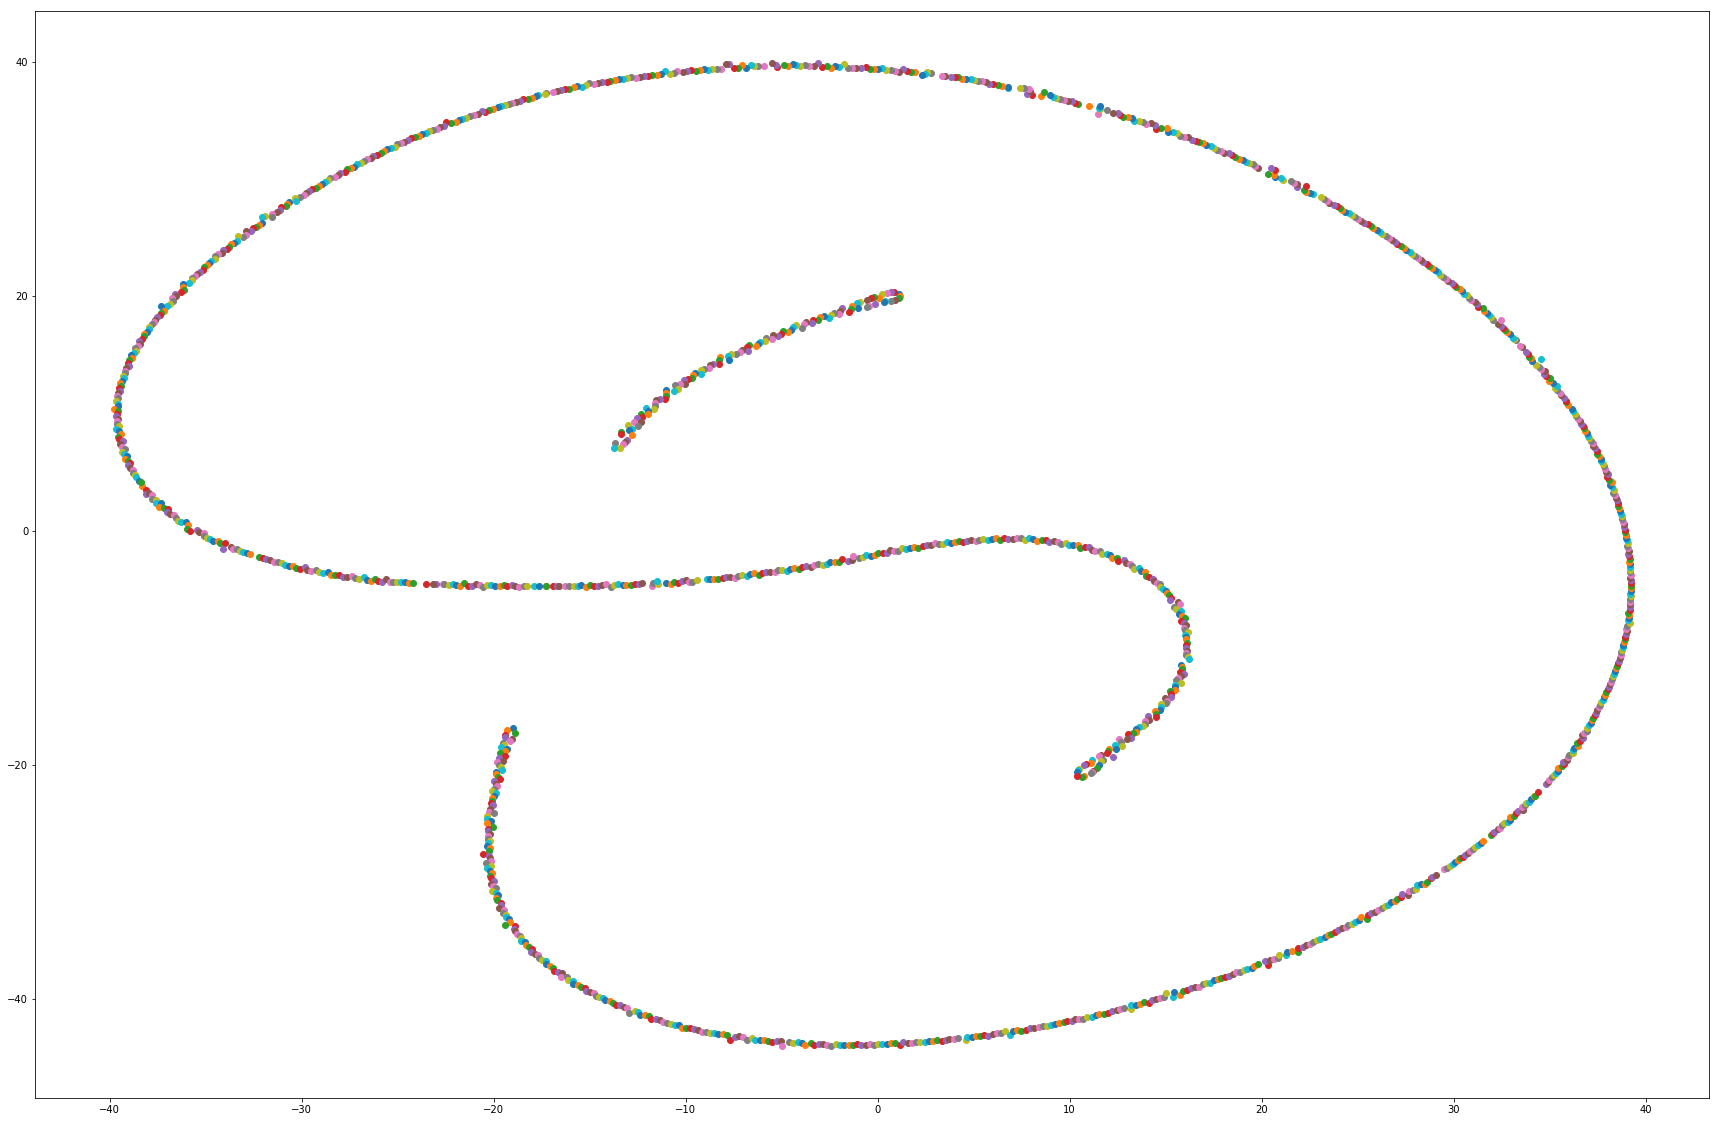

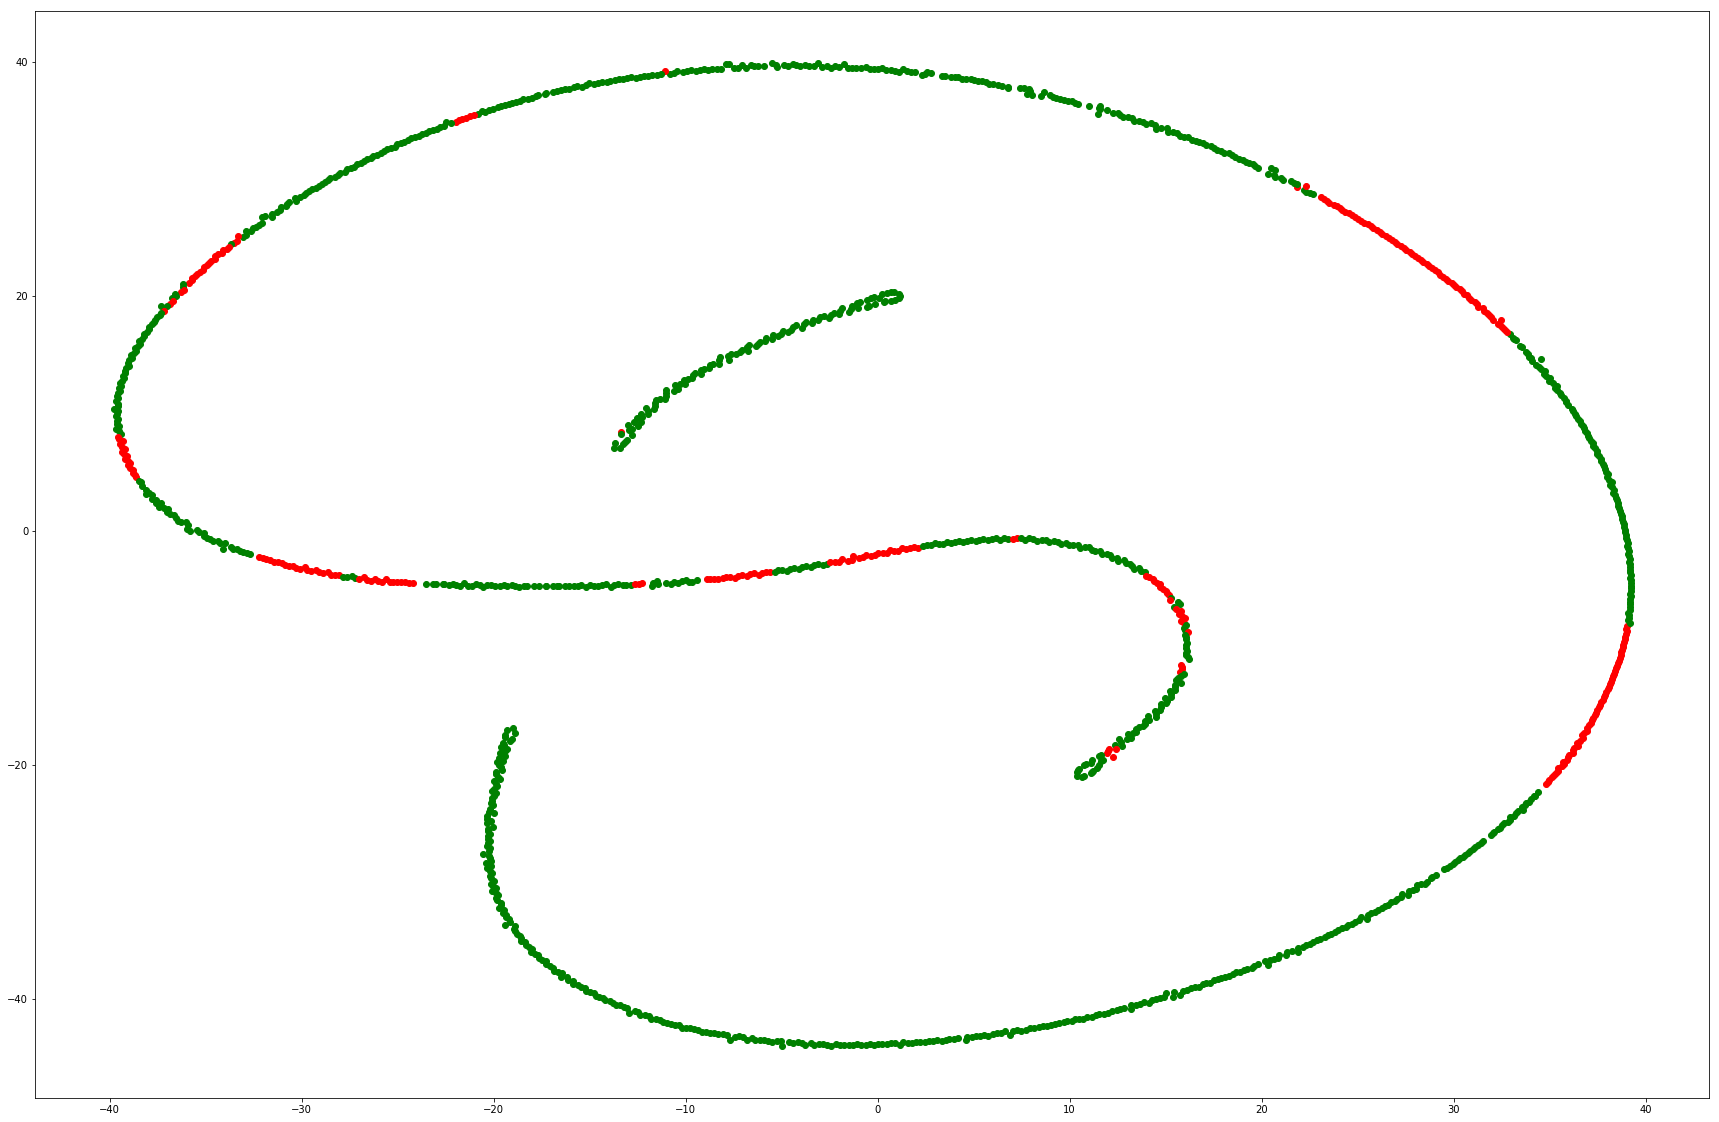

In [22]:
# import pandas as pd
# from sklearn.manifold import TSNE
# hidden5=pd.read_csv('./hidden5.csv')
# tsne = TSNE(n_components=2, random_state=0)
# hidden5_2D = tsne.fit_transform(hidden5)
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(30, 20))
for i in range(len(hidden5_2D)):
    plt.scatter(hidden5_2D[i,0],hidden5_2D[i,1])
plt.show()
EGFR_colored=[]
for i in RadiomicFeature.EGFR:
    if i==0:
        EGFR_colored.append('r')
    else:
        EGFR_colored.append('g')
plt.figure(figsize=(30, 20))
for i in range(len(hidden5)):
    plt.scatter(hidden5_2D[i,0],hidden5_2D[i,1],c=EGFR_colored[i])
plt.show()

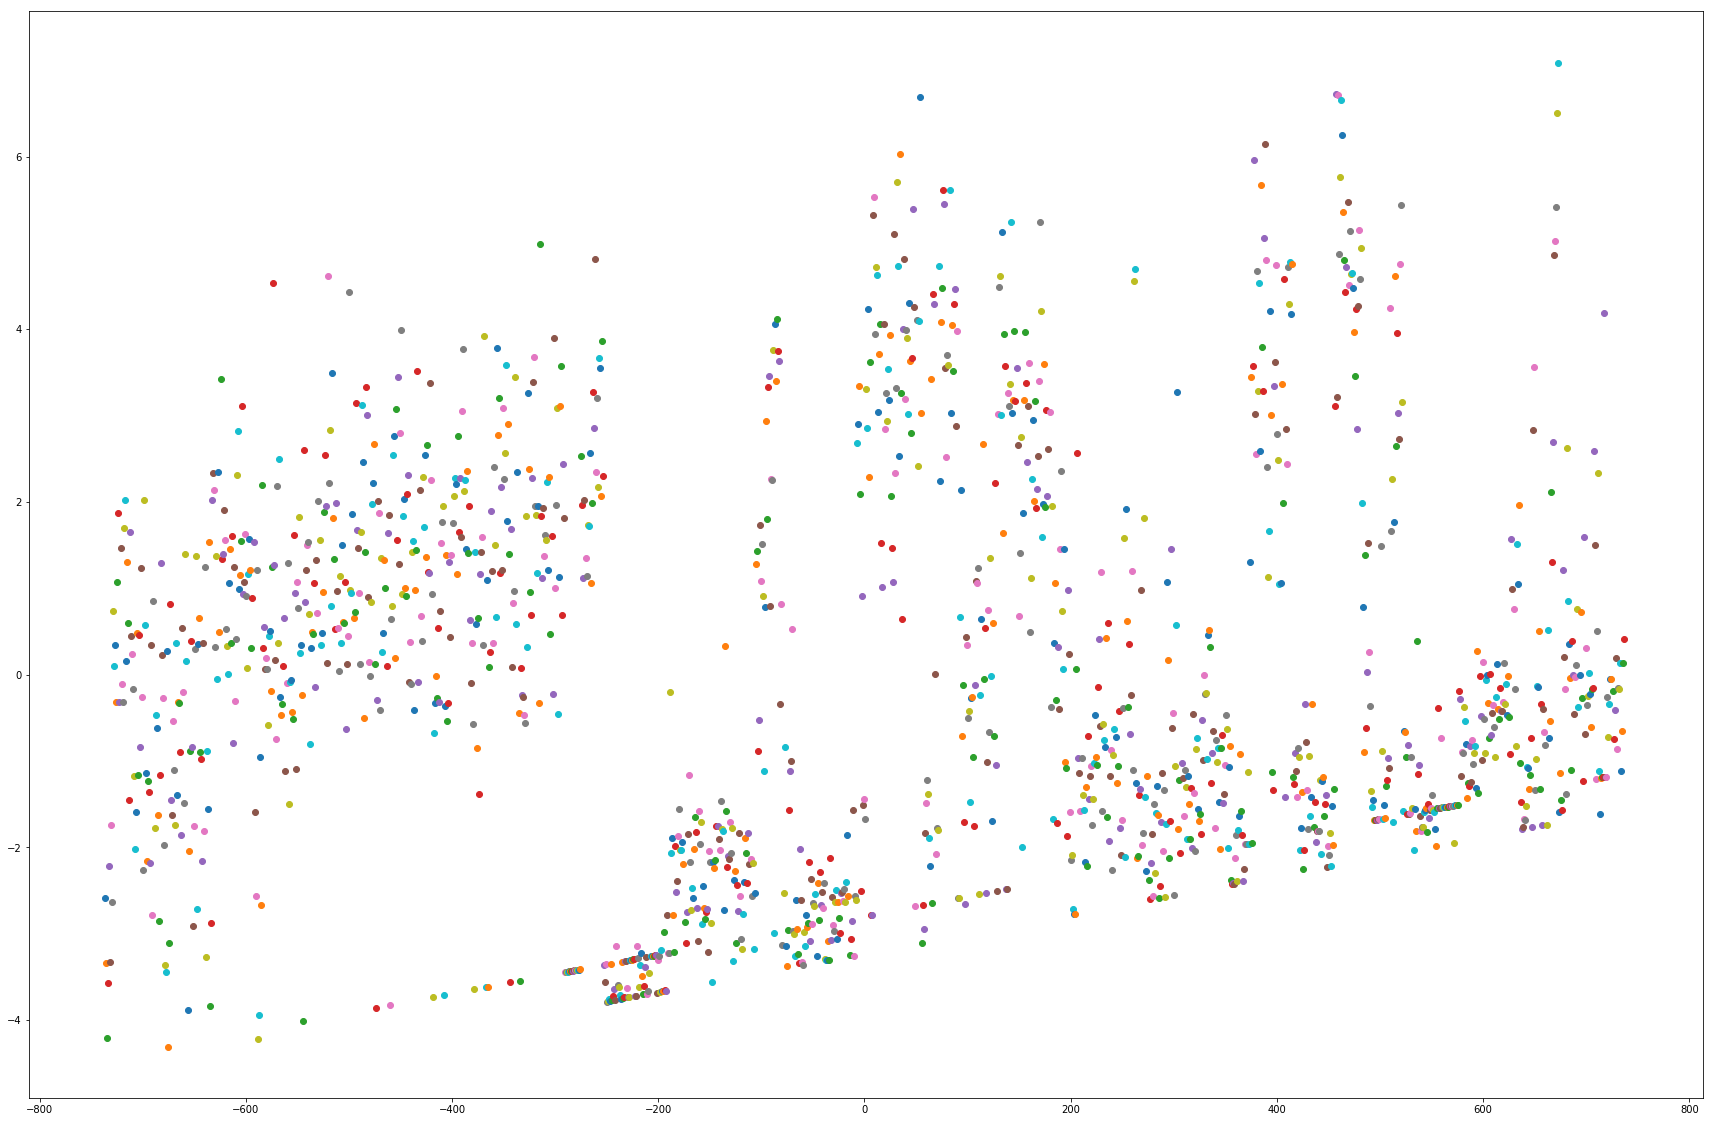

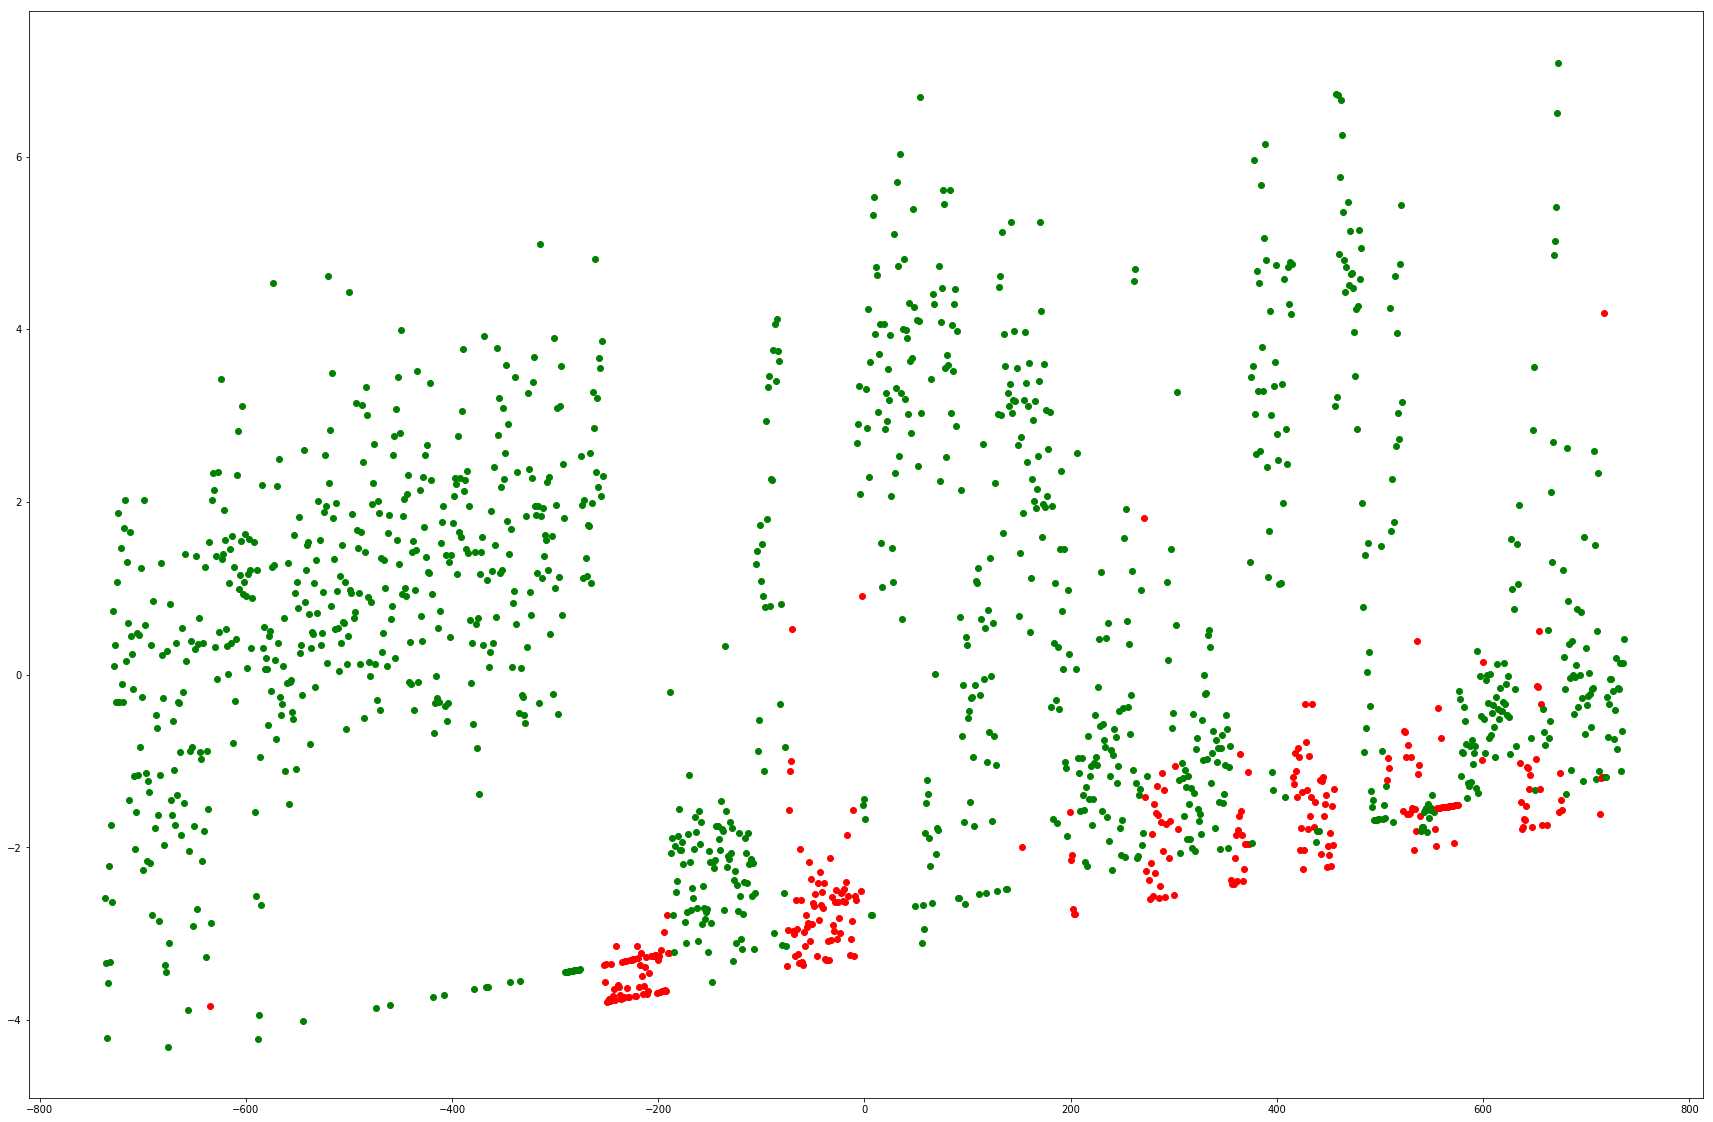

In [23]:
from sklearn.decomposition import PCA
# hidden5=pd.read_csv('./hidden5.csv')
pca = PCA(n_components=2, random_state=0)
hidden5_2D = pca.fit_transform(hidden5)
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(30, 20))
for i in range(len(hidden5_2D)):
    plt.scatter(hidden5_2D[i,0],hidden5_2D[i,1])
plt.show()
EGFR_colored=[]
for i in RadiomicFeature.EGFR:
    if i==0:
        EGFR_colored.append('r')
    else:
        EGFR_colored.append('g')
plt.figure(figsize=(30, 20))
for i in range(len(hidden5)):
    plt.scatter(hidden5_2D[i,0],hidden5_2D[i,1],c=EGFR_colored[i])
plt.show()

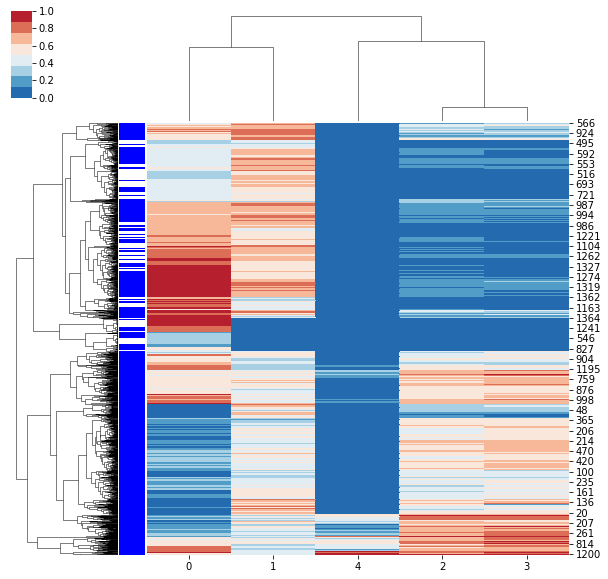

In [42]:
y_EGFR=RadiomicFeature.EGFR
y_ALK=RadiomicFeature.ALK
y_KRAS=RadiomicFeature.KRAS
EGFR_col=dict(zip(y_EGFR.unique(),'bw'))
ALK_col=dict(zip(y_ALK.unique(),'wg'))
KRAS_col=dict(zip(y_KRAS.unique(),'wr'))
ALK=y_ALK.map(ALK_col)
ALK.name='ALK'
EGFR=y_EGFR.map(EGFR_col)
EGFR.name='EGFR'
KRAS=y_KRAS.map(KRAS_col)
KRAS.name='KRAS'
import seaborn as sns
plt.figure(figsize=(20,20))
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(hidden5)
hidden51=scaler.transform(hidden5)
sns.clustermap(hidden51[:,[0,7,2,5,10]],row_colors=[EGFR],cmap=sns.color_palette("RdBu_r", 8)
              )
plt.show()

In [35]:
RUse.loc[:,[i for i in RUse.columns
                          if re.search('E3|E5',i)==None
                          and re.search('Edema',i)!=None ]].shape

(1474, 5500)

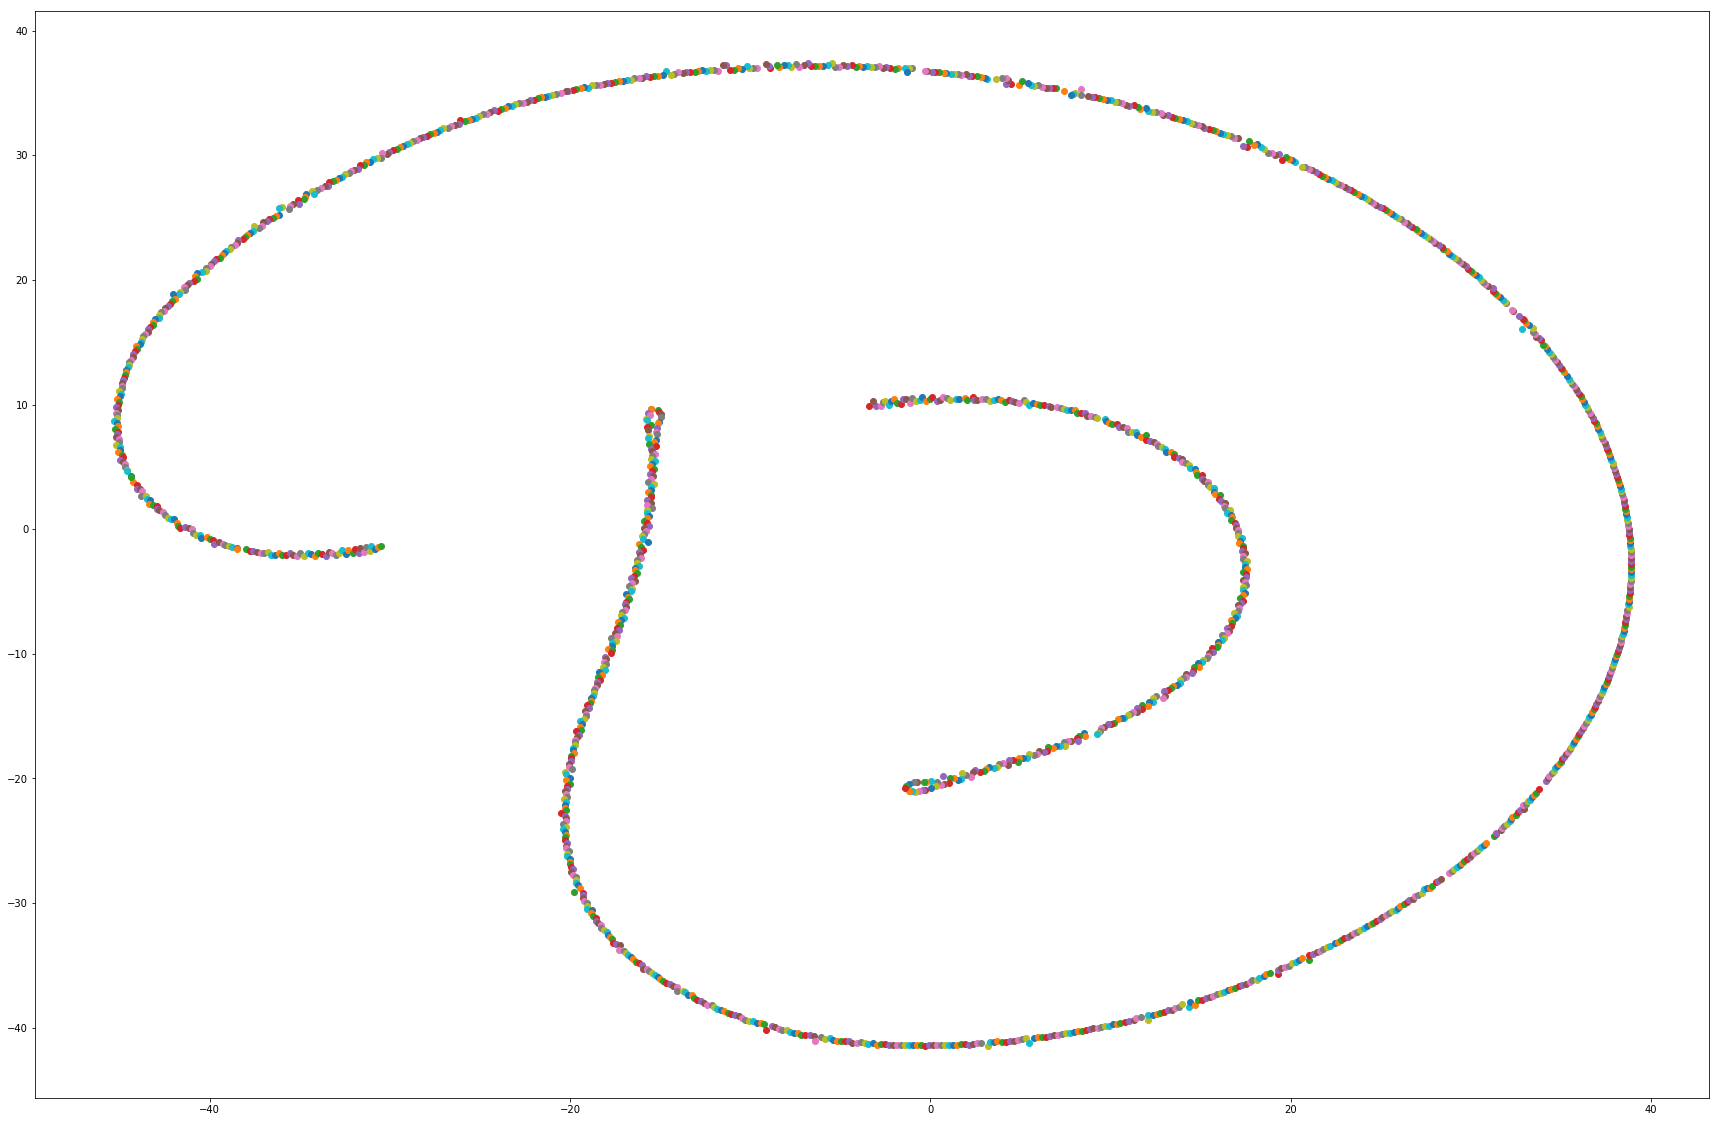

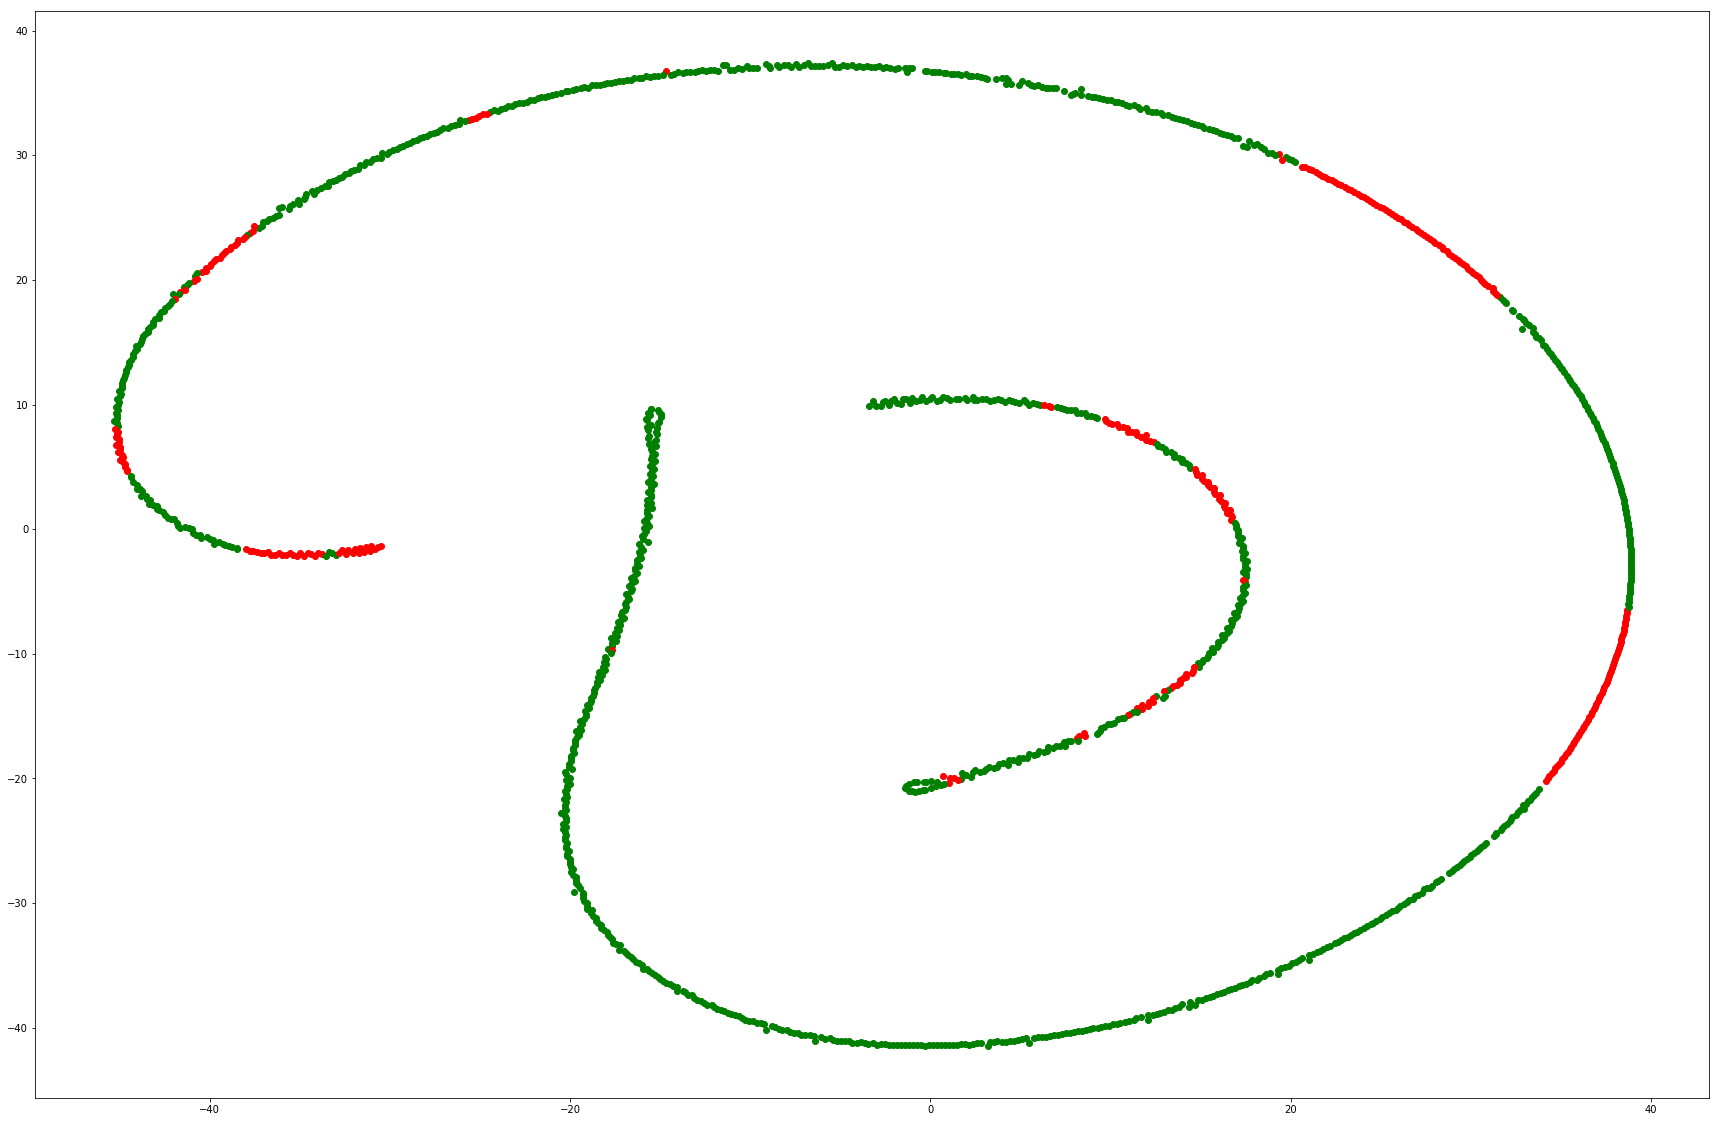

In [36]:
# import pandas as pd
# from sklearn.manifold import TSNE
hidden5_E=pd.read_csv('./hidden5_edema.csv')
# tsne = TSNE(n_components=2, random_state=0)
hidden5_2D = tsne.fit_transform(hidden5_E)
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(30, 20))
for i in range(len(hidden5_2D)):
    plt.scatter(hidden5_2D[i,0],hidden5_2D[i,1])
plt.show()
EGFR_colored=[]
for i in RadiomicFeature.EGFR:
    if i==0:
        EGFR_colored.append('r')
    else:
        EGFR_colored.append('g')
plt.figure(figsize=(30, 20))
for i in range(len(hidden5)):
    plt.scatter(hidden5_2D[i,0],hidden5_2D[i,1],c=EGFR_colored[i])
plt.show()

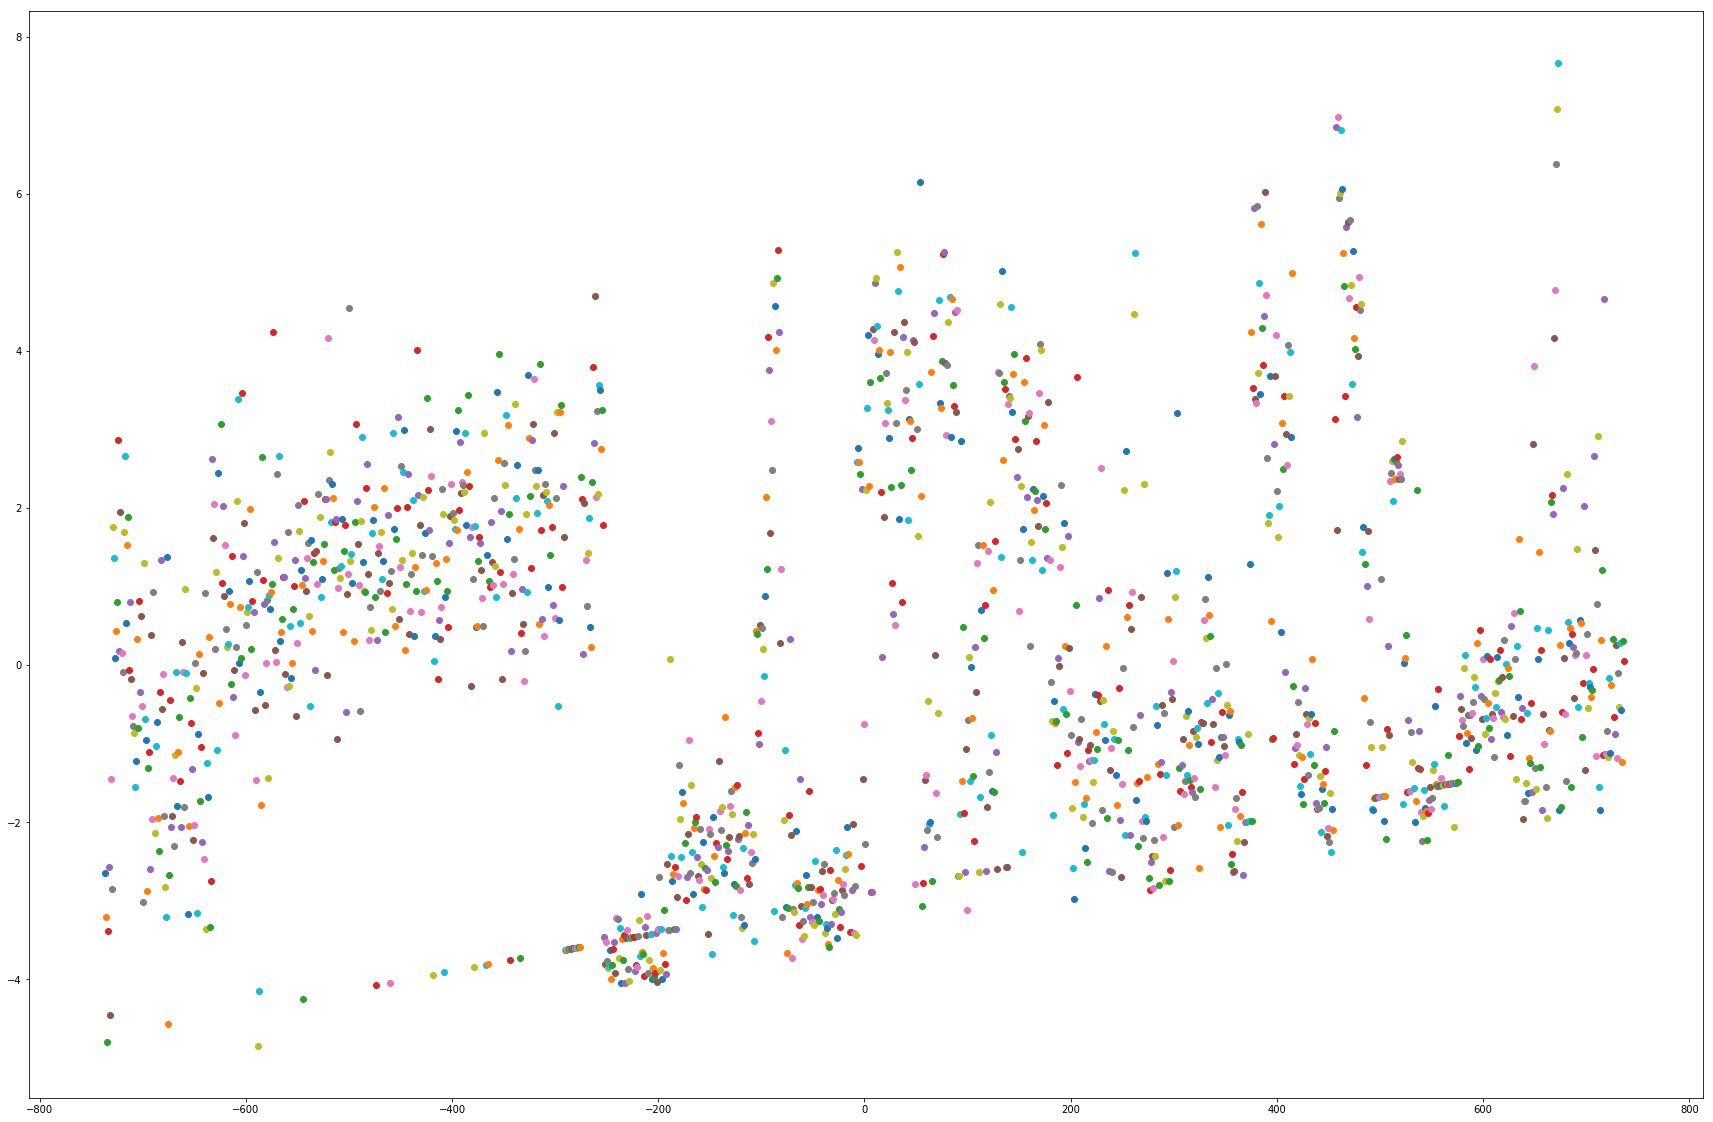

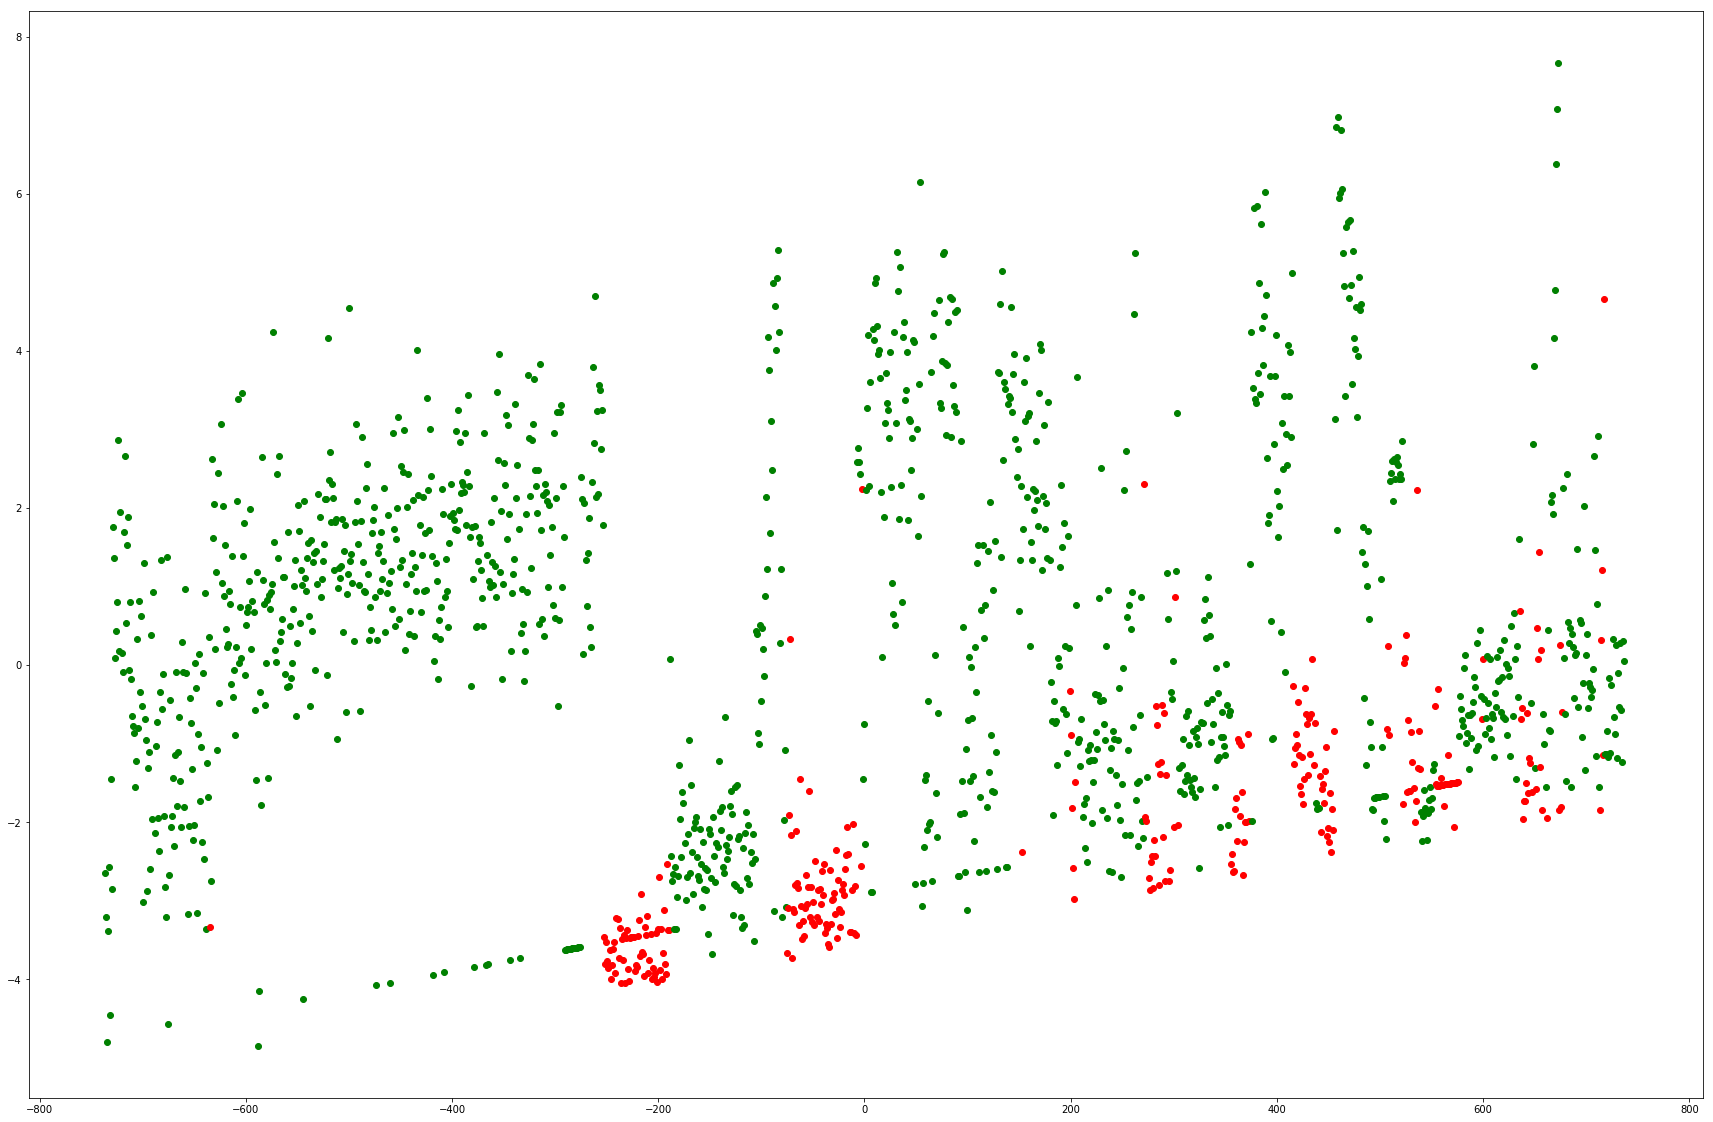

In [37]:
pca = PCA(n_components=2, random_state=0)
hidden5_2D = pca.fit_transform(hidden5_E)
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(30, 20))
for i in range(len(hidden5_2D)):
    plt.scatter(hidden5_2D[i,0],hidden5_2D[i,1])
plt.show()
EGFR_colored=[]
for i in RadiomicFeature.EGFR:
    if i==0:
        EGFR_colored.append('r')
    else:
        EGFR_colored.append('g')
plt.figure(figsize=(30, 20))
for i in range(len(hidden5)):
    plt.scatter(hidden5_2D[i,0],hidden5_2D[i,1],c=EGFR_colored[i])
plt.show()

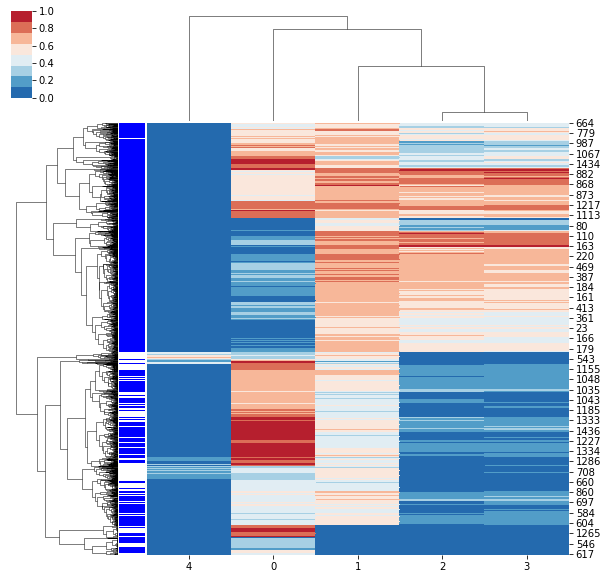

In [43]:
import seaborn as sns
plt.figure(figsize=(20,20))
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(hidden5_E)
hidden51=scaler.transform(hidden5_E)
sns.clustermap(hidden51[:,[0,5,2,4,7]],row_colors=[EGFR],cmap=sns.color_palette("RdBu_r", 8)
              )
plt.show()